# Training Word2Vec model








In [63]:
# common
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# languages
from underthesea import word_tokenize

#Modeling packages

# Word2vec
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors


In [64]:
# import data
df_new=pd.read_excel('data')


In [65]:
df_new['comment'].head(20)

0                           vải thô, không mềm, bị bạc.
1                      Vải dày mịn áo y hình rất đẹp❤️.
2     Mặc đi chơi không được, mặc ở nhà cũng không x...
3             Áo chật ngắn trong khi mình là người gầy.
4                                              Bộ chặt.
5         May vớt vội cái áo trắng chứ ko hỏng luôn áo.
6                                  Đây là tất cao cổ à?
7                              Mà rẻ z bảo sao vải đẹp.
8                            Chất vải không được đẹp...
9                                        Đường may xấu.
10                Chữ black hơi to không giống ảnh lắm.
11            Đặt lại sz S mà vẫn ship sai M cho mình .
12                                         Áo vải cứng.
13    Nhìn hình tưởng áo màu trắng tinh nhưng lại là...
14    Giao hàng nhanh đồ rất đẹp, đặt màu cam nhưng ...
15    Bọn lừa đảo.tao mua quần tặng vợ mà lai gửi ch...
16                                        Vải quá mõng.
17                       Phần zip trên túi k chắ

In [66]:
# WORD2VEC 
W2V_SIZE = 400
W2V_WINDOW = 10 # max distance bt the current and predicted
W2V_EPOCH = 35 
W2V_MIN_COUNT = 5 # Ignore word frequence < n
SEED = 567 # random


In [67]:
# Word2Vec model using Bag of word
w2v_model = Word2Vec(seed=SEED, 
                        vector_size=W2V_SIZE,
                        window=W2V_WINDOW,
                        min_count=W2V_MIN_COUNT
                        )

In [68]:
documents = [_text.split() for _text in df_new.comment_1.astype(str)]


In [69]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
w2v_model.build_vocab(tqdm(documents))

100%|██████████| 9904/9904 [00:00<00:00, 473713.23it/s]


In [70]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 1.57 s


(1092710, 2166955)

In [71]:
w2v_model.wv.most_similar(positive='tốt',topn=20)

[('rất_đẹp', 0.7073960304260254),
 ('rất_là', 0.6255791187286377),
 ('dài_dài', 0.6243530511856079),
 ('rất_ok', 0.6137076020240784),
 ('rất_ưng', 0.5899157524108887),
 ('rất_thích', 0.5848659873008728),
 ('rất_rất', 0.5824005603790283),
 ('rất_tốt', 0.5759737491607666),
 ('bền', 0.5651699304580688),
 ('cám_ơn', 0.5575745701789856),
 ('rất_tốt_shop', 0.5561677813529968),
 ('ưng_ý', 0.5552457571029663),
 ('tóm_lại', 0.5470220446586609),
 ('gọn', 0.5468549132347107),
 ('rất_tôn', 0.5364100337028503),
 ('cực_kì', 0.5278401374816895),
 ('bàn', 0.5203929543495178),
 ('rất_sang', 0.519592821598053),
 ('rất_hài_lòng', 0.5119981169700623),
 ('thân_thiện', 0.5060713291168213)]

In [74]:
w2v_model.save("w2v.model")

# Sentence2vec




In [75]:
import re
import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from underthesea import word_tokenize


In [76]:
# Sentence2vec based on Word2Vec 
class Sentence2Vec:
    def __init__(self, model_file):
        self.load(model_file)

    def load(self, model_file):
        self.model = Word2Vec.load(model_file)

    def get_vector(self, sentence):
        vectors = [self.model.wv[w] for w in word_tokenize(sentence)
                   if w in self.model.wv]

        v = np.zeros(self.model.vector_size)

        if (len(vectors) > 0):
            v = (np.array([sum(x) for x in zip(*vectors)])) / v.size
        return v

    def similarity(self, x, y):
        xv = self.get_vector(x)
        yv = self.get_vector(y)

        score = 0

        if xv.size > 0 and yv.size > 0:
            score = dot(xv, yv) / (norm(xv) * norm(yv))

        return score


In [77]:
model = Sentence2Vec('w2v.model')

In [78]:
matrix = np.zeros((len(documents),W2V_SIZE))
for i in range(len(documents)):
        matrix[i] = model.get_vector(str(documents[i]))
print(matrix.shape)

(9904, 400)


# PCA to reduce dimention (40D)




In [80]:
from sklearn.decomposition import PCA

# fit a 40d PCA model to the vectors
pca = PCA(n_components=80)
PCA_result = pca.fit_transform(matrix)
print(PCA_result.shape)

(9904, 80)


# K-mean clustering

In [90]:
iteration = 20
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=iteration,normalise= True ,avoid_empty_clusters= True)
assigned_clusters = kclusterer.cluster(PCA_result, assign_clusters=True)


In [91]:
assigned_clusters = np.array(assigned_clusters)

# **Result**

In [92]:
pca = PCA(n_components=2)
PCA_new = pca.fit_transform(matrix)

In [93]:
d = {'document' : df_new["comment"], 'label':assigned_clusters, 'x': PCA_new[:,0], 'y': PCA_new[:,1]}
df = pd.DataFrame(data=d)

In [99]:
#filter rows of original data
filtered_label0 = df[assigned_clusters == 0]
filtered_label1 = df[assigned_clusters == 1]
filtered_label2 = df[assigned_clusters == 2]


In [95]:
filtered_label0.head(60)

,document,label,x,y
0,"vải thô, không mềm, bị bạc.",0,-0.023309,-0.013347
4,Bộ chặt.,0,-0.018224,-0.009850
5,May vớt vội cái áo trắng chứ ko hỏng luôn áo.,0,-0.018469,-0.000031
6,Đây là tất cao cổ à?,0,-0.022993,-0.007361
7,Mà rẻ z bảo sao vải đẹp.,0,-0.003242,-0.005982
8,Chất vải không được đẹp...,0,-0.012317,-0.011569
9,Đường may xấu.,0,-0.019442,-0.011973
10,Chữ black hơi to không giống ảnh lắm.,0,-0.021227,-0.002752
12,Áo vải cứng.,0,-0.019767,-0.012276
13,Nhìn hình tưởng áo màu trắng tinh nhưng lại là...,0,-0.016817,0.007553


In [96]:
filtered_label1.head(50)

,document,label,x,y
2,"Mặc đi chơi không được, mặc ở nhà cũng không x...",1,-0.023360,0.007559
3,Áo chật ngắn trong khi mình là người gầy.,1,-0.023531,0.009631
11,Đặt lại sz S mà vẫn ship sai M cho mình .,1,0.002531,0.042869
24,Cổ áo qá rộng.,1,-0.021090,0.003407
26,Quần form bé.,1,-0.015104,0.016798
27,Kg hiểu sao 2 cái 1 mỏng 1 dày!?,1,-0.014831,0.000221
28,Áo ngắn quá mô mặc đc .....,1,-0.025242,0.002958
29,Đừơg may rất ẩu.nhíu ngay cổ áo ko mặc dc.bực ...,1,-0.015592,0.004307
38,Còn cái size s thì bị mốc.,1,-0.014964,0.000213
43,Size s ngực 110.,1,-0.021650,0.003327


In [97]:
filtered_label2.head(50)

,document,label,x,y
1,Vải dày mịn áo y hình rất đẹp❤️.,2,0.007772,-0.012560
14,"Giao hàng nhanh đồ rất đẹp, đặt màu cam nhưng ...",2,0.034407,0.032292
15,Bọn lừa đảo.tao mua quần tặng vợ mà lai gửi ch...,2,0.020658,0.024694
22,Shop khâu vá lại.,2,0.006652,0.001593
23,"Vải khá mỏng và rất cũ, giao hàng khá nhanh.",2,0.031094,-0.004915
30,"hàng bị lỗi sau giày , sản phẩm đóng gói hộp b...",2,0.032137,-0.012513
40,"Vải cũng đẹp nhưng đường may ko cẩn thận, đã c...",2,0.011023,-0.000483
42,Chất lượng sản phẩm tạm được so với giá. áo kh...,2,0.005142,-0.016620
65,"Mình mua của shop này rất nhiều lần,vì mình cũ...",2,0.041913,0.044094
97,"Hàng y hình,nhưng ko co giãn,mặc vào cởi ra rấ...",2,0.000907,-0.002430


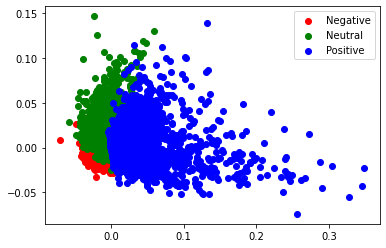

In [100]:
#Plotting the results
fig, ax = plt.subplots()
scatter0= plt.scatter(filtered_label0['x'] , filtered_label0['y'] , color = 'red')
scatter1 = plt.scatter(filtered_label1['x'] , filtered_label1['y'] , color = 'green')
scatter2 = plt.scatter(filtered_label2['x'] , filtered_label2['y'] , color = 'blue')
ax.legend([scatter0, scatter1, scatter2], ['Negative', 'Neutral', 'Positive'])

plt.show()
